In [1]:
# Import Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import ExtraTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotly.offline import iplot
from plotly.subplots import make_subplots
import plotly.io as pio
pio.renderers.default = "svg"

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load the data
data = pd.read_csv('winequalityN.csv')

In [3]:
data.head()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,white,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,white,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [4]:
data.shape

(6497, 13)

## 1. Missing Value

In [5]:
data.isnull().sum()

type                     0
fixed acidity           10
volatile acidity         8
citric acid              3
residual sugar           2
chlorides                2
free sulfur dioxide      0
total sulfur dioxide     0
density                  0
pH                       9
sulphates                4
alcohol                  0
quality                  0
dtype: int64

In [6]:
# data['residual sugar'].fillna(data['residual sugar'].mean(), inplace = True)
# data['chlorides'].fillna(data['chlorides'].mean(), inplace = True)
data['citric acid'].fillna(data['citric acid'].mean(), inplace = True)
data['sulphates'].fillna(data['sulphates'].mean(), inplace = True)
data['volatile acidity'].fillna(data['volatile acidity'].mean(), inplace = True)
data['pH'].fillna(data['pH'].mean(), inplace = True)
data['fixed acidity'].fillna(data['fixed acidity'].mean(), inplace = True)
# data.dropna(inplace = True)

## 2. Exploratory Data Analysis

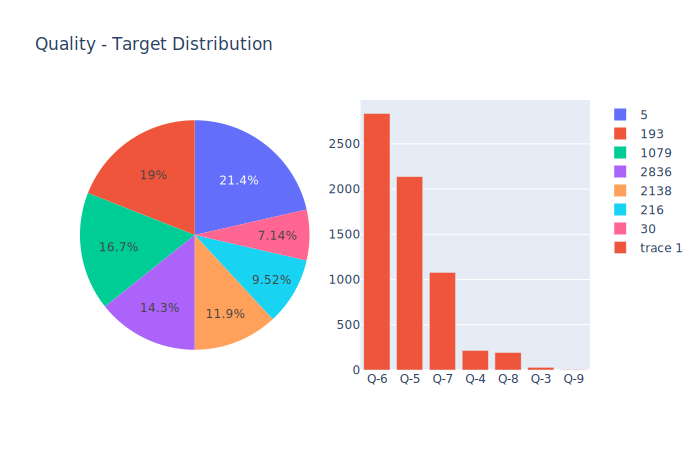

In [7]:
# 1. Quality

df_quality = data['quality'].value_counts()
quality_index = []
quality_values = []
for i in df_quality.index:
    quality_index.append('Q-' + str(i))
for i in df_quality.values:
    quality_values.append(str(i))
    
fig = make_subplots(rows = 1, cols = 2, specs=[[{"type": "pie"}, {"type": "bar"}]])

fig.add_trace(go.Pie(values = df_quality.index,
              labels = df_quality.values), row = 1, col = 1)
fig.add_trace(go.Bar(x = quality_index,
              y = quality_values), row = 1, col = 2)
fig['layout'].update(title = 'Quality - Target Distribution')
iplot(fig)

<AxesSubplot:xlabel='type', ylabel='quality'>

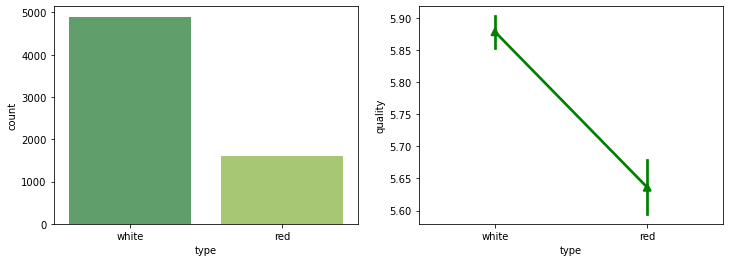

In [8]:
# 2. Type
plt.rcParams['figure.figsize'] = (12, 4)
plt.subplot(121)
sns.countplot(data['type'] , palette = 'summer')
plt.subplot(122)
sns.pointplot(x = data['type'], y = data['quality'], color = 'green', markers = '^')

#### We have more White wines and the quality of White wines are higher than of Red wine

In [9]:
numerical_features = []
for col in data:
    if data[col].dtypes == 'float64':
        numerical_features.append(col)

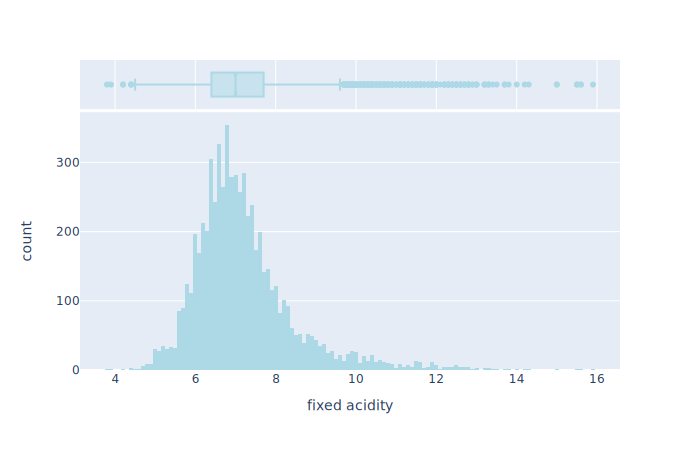

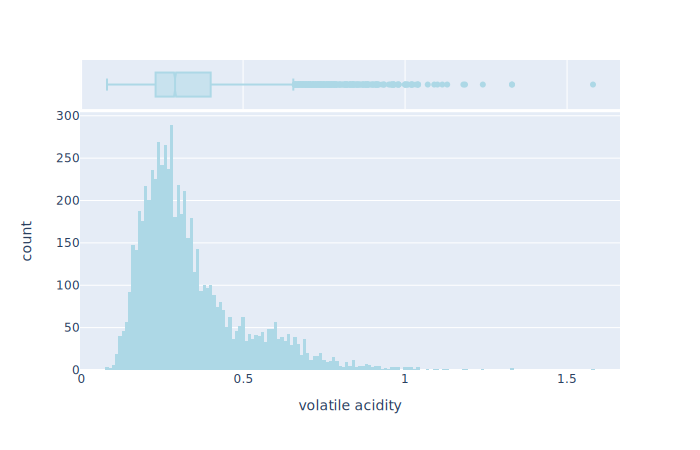

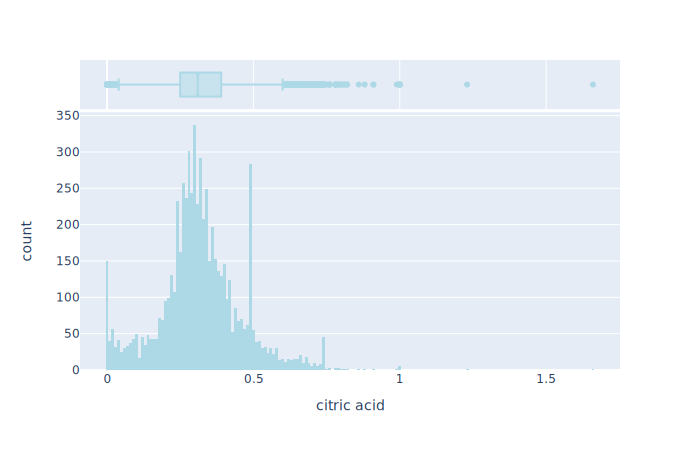

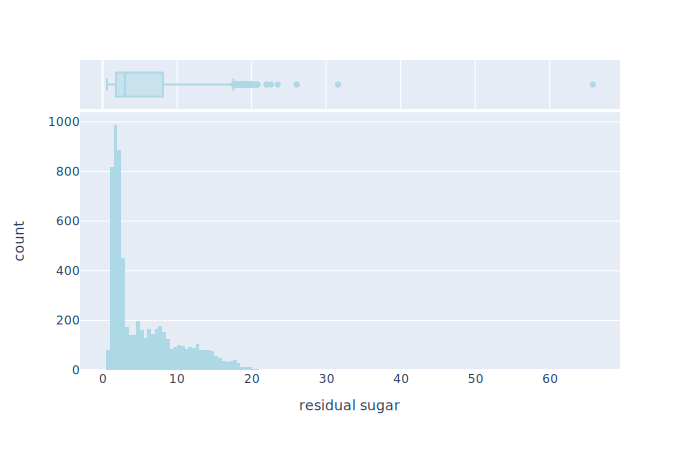

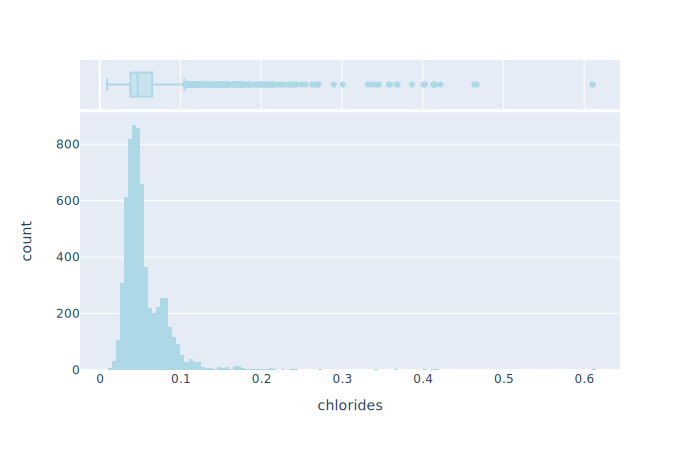

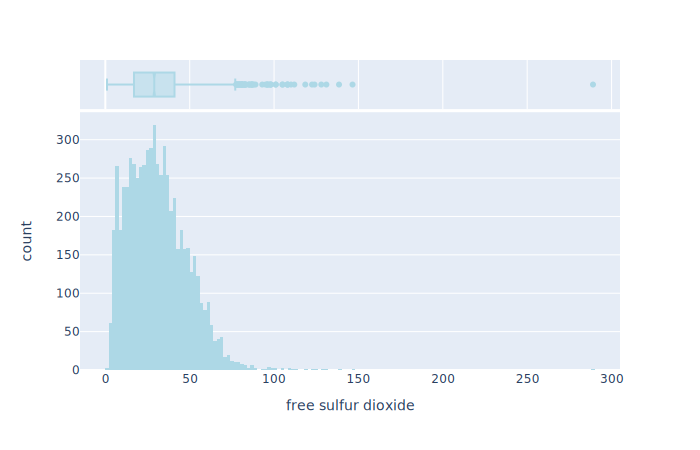

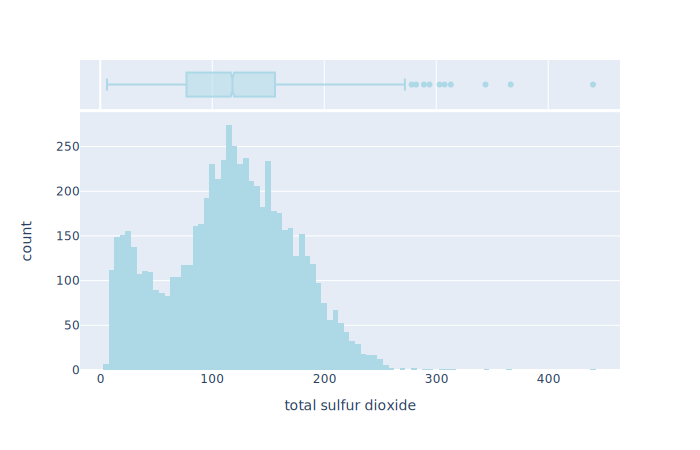

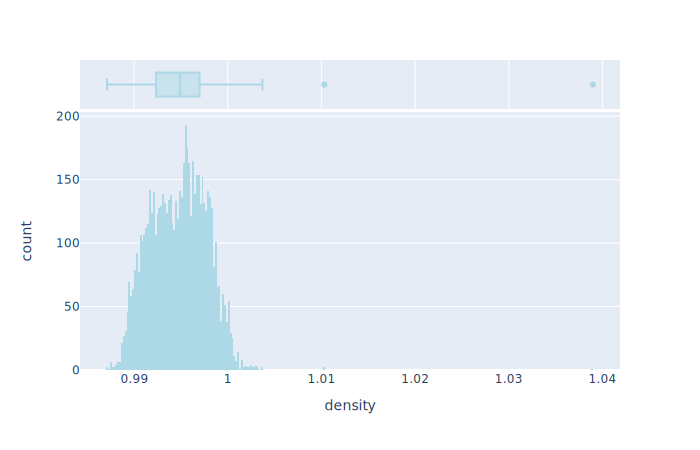

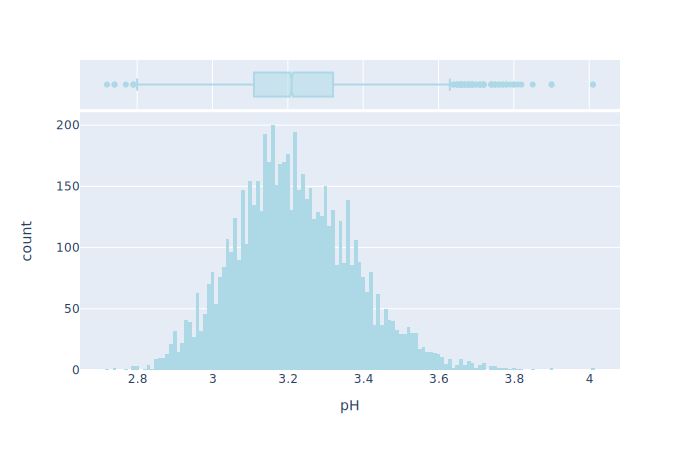

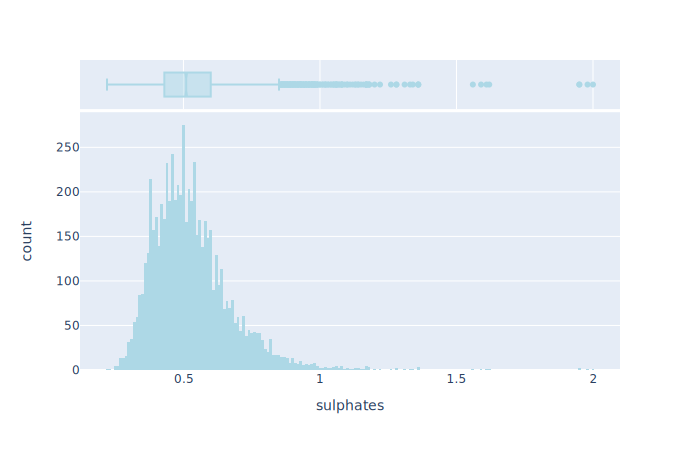

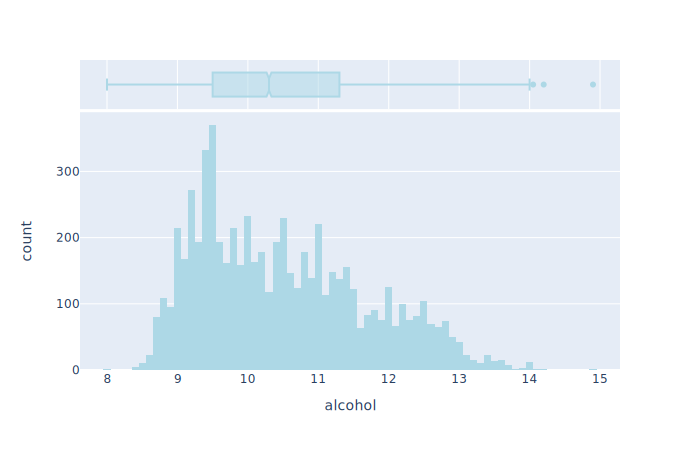

In [10]:
for feature in numerical_features:
    fig = px.histogram(data, x = feature, marginal = 'box', color_discrete_sequence=['lightblue'] )
    fig.show()

#### We need to fix the Outliers as it might impact our prediction of the Wine Quality

<AxesSubplot:>

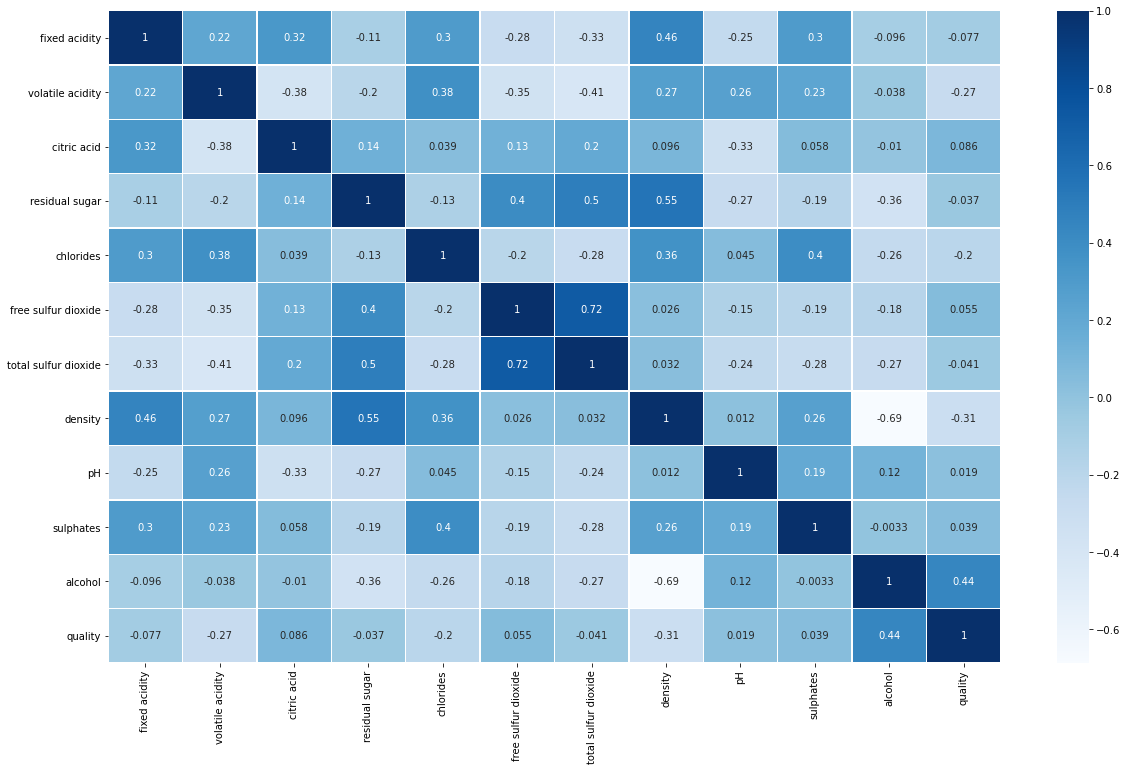

In [11]:
plt.rcParams['figure.figsize'] = (20, 12)
sns.heatmap(data.corr(), annot = True, linewidths = 0.4, cmap = 'Blues' )


* Free sulfur dioxide & total sulfur dioxide are highly correlated
* Alcohol & Density are negativley correlated
* Alcohol & Quality are positively correlated

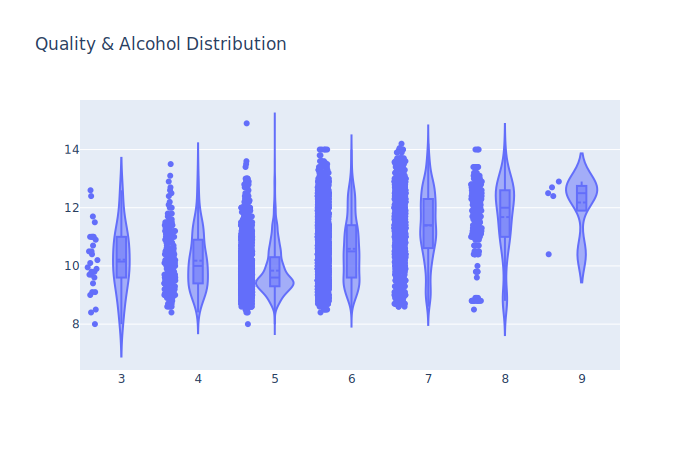

In [12]:
data1 = go.Violin(x = data['quality'], y = data['alcohol'], box_visible=True,
                            meanline_visible=True, points='all')
fig = go.Figure([data1])
fig['layout'].update( title = 'Quality & Alcohol Distribution', width = 1000, height = 500)
fig.show()

#### Wine with higer quatity of alcohol is of better quality

In [13]:
# quaity_mapping = { 3 : "Low",4 : "Low",5: "Medium",6 : "Medium",7: "Medium",8 : "High",9 : "High"}
# data["quality"] =  data["quality"].map(quaity_mapping)
# mapping_quality = {"Low" : 0,"Medium": 1,"High" : 2}
# data["quality"] =  data["quality"].map(mapping_quality)

## 3. Feature Engineering 

In [14]:
# Fixing the Outliers
def remove_outliers(feature):
    Q1 = data[feature].quantile(0.25)
    Q3 = data[feature].quantile(0.75)
    IQR = Q3 - Q1 
    lower_limit = Q1 - (3*IQR)
    upper_limit = Q3 + (3*IQR)
    return data[(data[feature] > lower_limit) & (data[feature] < upper_limit)]

In [15]:
outlier_features = ['residual sugar','total sulfur dioxide', 'free sulfur dioxide','fixed acidity','volatile acidity']
for feature in numerical_features:
    data = remove_outliers(feature)

In [16]:
dummies = pd.get_dummies(data['type'], drop_first = True)
data = pd.concat([data, dummies], axis = 1)

In [17]:
data.drop(['type'], axis = 1, inplace = True)

In [18]:
for feature in data.columns:
    if data[feature].skew() > 0.3:
        data[feature] = np.log1p(data[feature])

## 4. Model Training

In [19]:
# Precision, Recall & F1 - Score
def show_metrics(y_test, y_pred):
    print('Precision Score : {:.3f}'.format(precision_score(y_test, y_pred, average = 'weighted')))
    print('Recall Score : {:.3f} '.format(recall_score(y_test, y_pred, average = 'weighted')))
    print('F1 Score : {:.3f}'.format(f1_score(y_test, y_pred, average = 'weighted')))
    print('Accuracy Score : {:.3f}'.format(accuracy_score(y_test, y_pred)))

In [20]:
# Feature Importance Plot
def feature_importance_plot(feature_importances, features):
    df_features = pd.DataFrame({'Feature': features, 'Feature Importance' : feature_importances})
    df_features.sort_values(by = 'Feature Importance', ascending = False, inplace = True)
    plt.rcParams['figure.figsize'] = (20,10)
    sns.barplot(x = 'Feature Importance', y = 'Feature', data = df_features)

In [21]:
# Independent & Dependent Variable

X = data.drop(['quality','free sulfur dioxide','residual sugar','white'], axis = 1)
y = data['quality']

In [22]:
# Train & Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

In [23]:
# Cross Validation

scores = []
std = []
accuracy = []
kfold = KFold(n_splits = 10)
classifiers = ('Logistic Regression', 'Naive Bayes', 'SVM', 'Decision Tree', 'Random Forest', 'ExtraTreeClassifier')
models = [
    LogisticRegression(),
    GaussianNB(),
    SVC(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    ExtraTreeClassifier()
]

for model in models:
    cv_result = cross_val_score(model, X, y, cv = kfold, scoring = 'accuracy')
    scores.append(cv_result.mean())
    std.append(cv_result.std())
    accuracy.append(cv_result)
model_result_df = pd.DataFrame({'Mean': scores, 'Std':std}, index = classifiers).sort_values(by = 'Mean', ascending = True)
model_accuracy = pd.DataFrame(accuracy , index = classifiers)
model_result_df

,Mean,Std
Decision Tree,0.420566,0.043670
ExtraTreeClassifier,0.422996,0.029575
SVM,0.437128,0.040460
Logistic Regression,0.458579,0.038316
Naive Bayes,0.483584,0.031957
Random Forest,0.534148,0.042777


<AxesSubplot:>

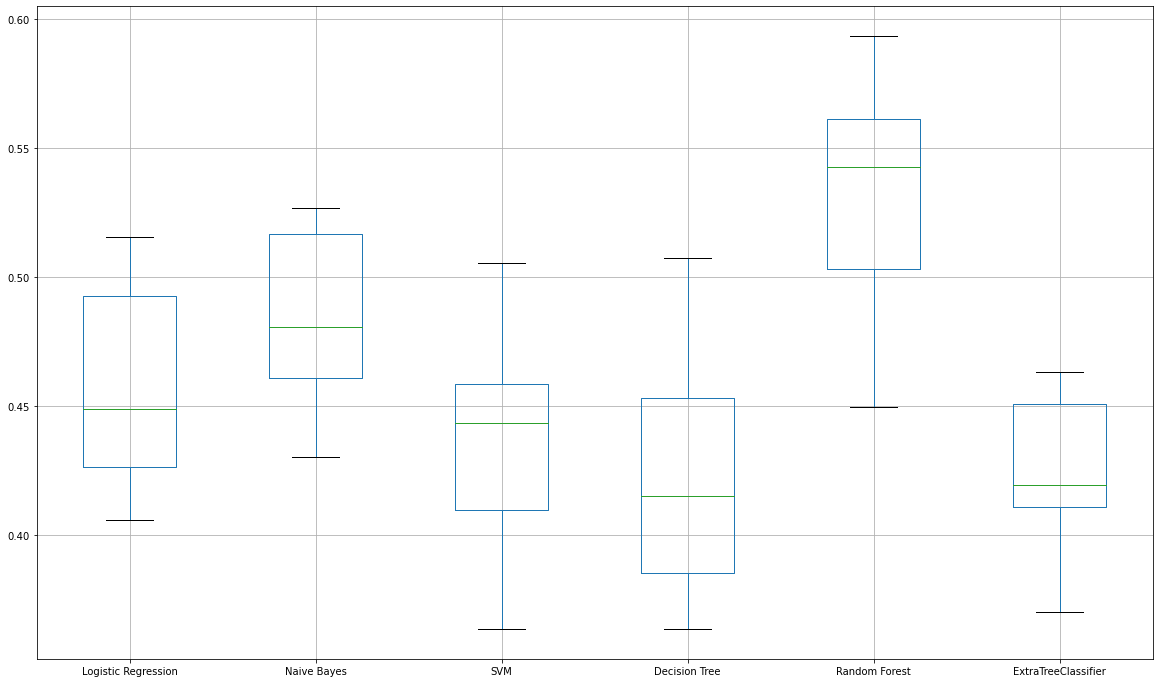

In [24]:
model_accuracy.T.boxplot()

In [25]:
data.sample(7)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,white
6053,2.230014,0.470004,0.25,1.163151,0.111541,2.302585,38.0,0.99616,1.423108,0.425268,2.379546,5,0
666,2.054124,0.198851,0.37,0.993252,0.035367,3.663562,195.0,0.99080,1.470176,0.542324,2.602690,6,1
2637,2.272126,0.270027,0.73,2.731115,0.043059,3.332205,191.0,1.00013,1.376244,0.631272,2.272126,5,1
4442,2.041220,0.292670,0.31,2.856470,0.049742,3.044522,146.0,0.99834,1.401183,0.431782,2.312535,5,1
585,2.128232,0.215111,0.22,2.459589,0.041142,3.295837,81.0,0.99540,1.350667,0.307485,2.370244,6,1
4137,2.128232,0.270027,0.26,2.261763,0.046884,3.871201,206.0,0.99640,1.449269,0.307485,2.312535,5,1
2999,2.054124,0.165514,0.28,2.379546,0.038259,3.401197,113.0,0.99406,1.413423,0.371564,2.476538,7,1


In [26]:
# Hyper Parameter Tunning for SVM

svc_model = SVC()
params = {
    'C' : [ 1, 10, 20],
    'kernel' : ['linear', 'rbf']
    
}
gd = GridSearchCV(estimator = svc_model, param_grid = params, verbose = True)
# gd.fit(X, y)
# print(gd.best_score_)
# print(gd.best_params_)

In [27]:
# Hyper Parameter Tunning for Random Forest

rf_model = RandomForestClassifier()
n_estimator = [600, 700, 800, 900, 1000]
params = {
    "n_estimators": n_estimator,
    "max_depth":[9, 10, 15, 20, 30]
}
gd = GridSearchCV(estimator = rf_model, param_grid = params, verbose = True)
# gd.fit(X, y)
# print(gd.best_score_)
# print(gd.best_params_)

In [28]:
rf_model = RandomForestClassifier(max_depth = 9, n_estimators = 900)
rf_model.fit(X_train, y_train)
rf_predict = rf_model.predict(X_test)
show_metrics(y_test, rf_predict)

Precision Score : 0.652
Recall Score : 0.633 
F1 Score : 0.612
Accuracy Score : 0.633


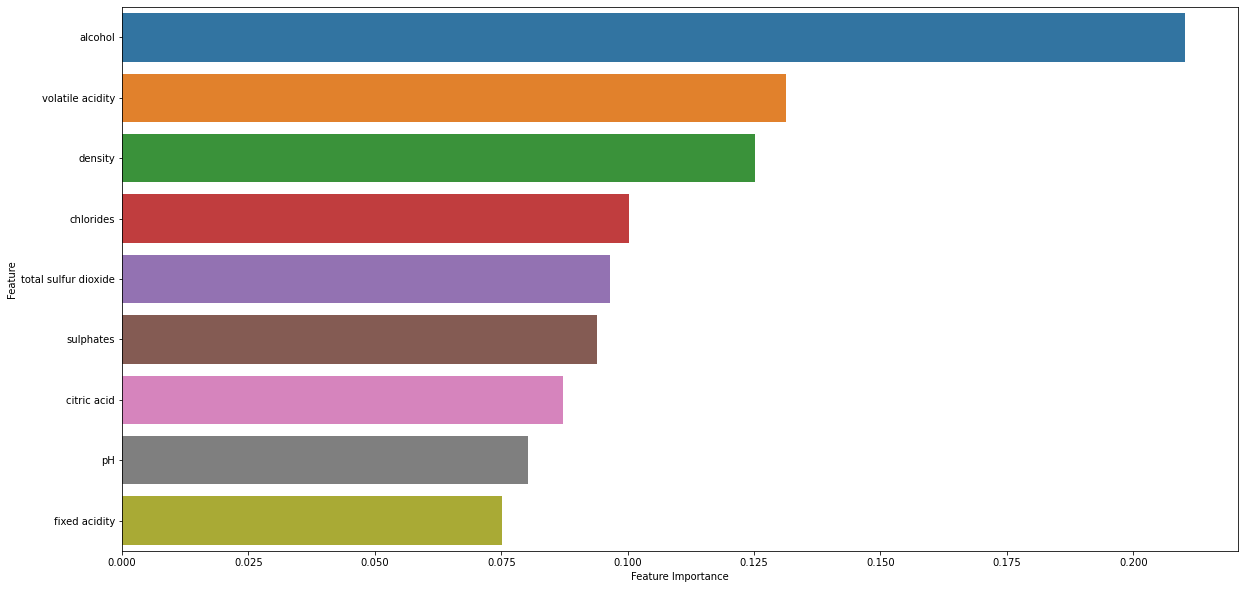

In [30]:
feature_importance_plot(rf_model.feature_importances_, X_train.columns)